[End to end](https://deepdow.readthedocs.io/en/latest/auto_examples/end_to_end/getting_started.html)

In [1]:
from deepdow.benchmarks import Benchmark, OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
torch.manual_seed(4)
np.random.seed(5)

In [3]:
n_timesteps, n_assets = 1000, 20
lookback, gap, horizon = 40, 2, 20
n_samples = n_timesteps - lookback - horizon - gap + 1

In [4]:
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:750
Test range: 811:938


In [5]:
returns = np.array([sin_single(n_timesteps,
                               freq=1 / np.random.randint(3, lookback),
                               amplitude=0.05,
                               phase=np.random.randint(0, lookback)
                               ) for _ in range(n_assets)]).T

In [6]:
returns += np.random.normal(scale=0.02, size=returns.shape)

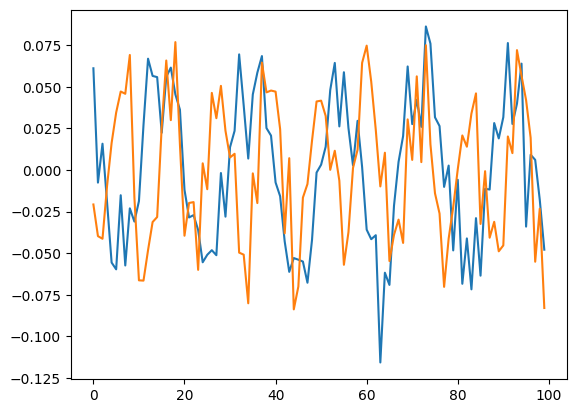

In [7]:
plt.plot(returns[:100, [1, 2]])

In [8]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(returns[i - lookback: i, :])
    y_list.append(returns[i + gap: i + gap + horizon, :])

X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]

print('X: {}, y: {}'.format(X.shape, y.shape))

X: (939, 1, 40, 20), y: (939, 1, 20, 20)


In [9]:
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [-9.56904164e-07], std: [0.04066513]


In [10]:
dataset = InRAMDataset(X, y, transform=Scale(means, stds))

In [11]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)

In [12]:
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):
        super().__init__()

        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_features, n_assets, bias=True)
        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, 1, lookback, n_assets).

        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).

        """
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  # flatten features
        x = self.dropout_layer(x)
        x = self.dense_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)

        return weights

In [13]:
network = GreatNet(n_assets, lookback)
print(network)

GreatNet(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (dense_layer): Linear(in_features=800, out_features=20, bias=True)
  (allocate_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


In [14]:
network = network.train()  # it is the default, however, just to make the distinction clear

In [15]:
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()

In [16]:
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)])

In [17]:
history = run.launch(30)

Epoch 29: 100%|██████████| 24/24 [00:00<00:00, 104.43it/s, loss=-0.90944, test_loss=-0.71638]


In [18]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model    epoch
test        loss    network  0        128
                             1        128
                             2        128
                             3        128
                             4        128
                             5        128
                             6        128
                             7        128
                             8        128
                             9        128
                             10       128
                             11       128
                             12       128
                             13       128
                             14       128
                             15       128
                             16       128
                             17       128
                             18       128
                             19       128
                             20       128
                             21       128
                             22       128

<Axes: xlabel='epoch'>

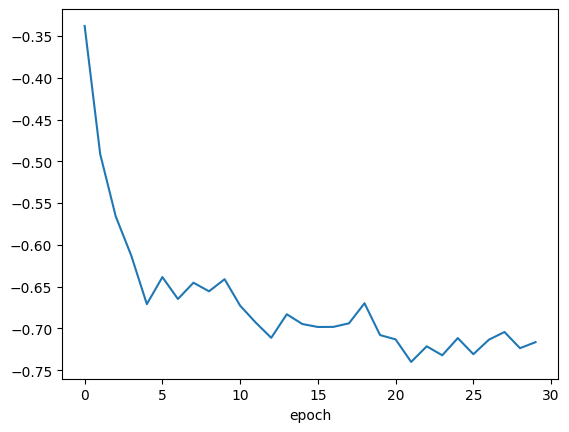

In [19]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [20]:
network = network.eval()

In [21]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}

In [22]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [23]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics)

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

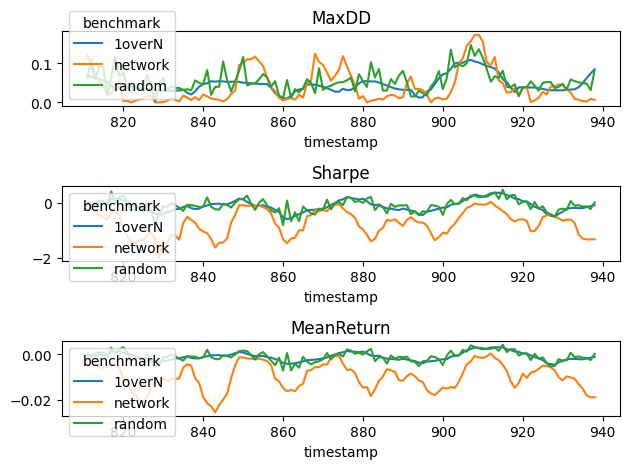

In [24]:
plot_metrics(metrics_table)

In [25]:
weight_table = generate_weights_table(network, dataloader_test)

<Axes: >

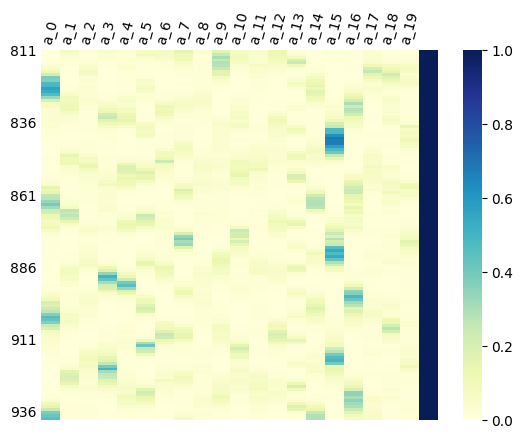

In [26]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)